In [3]:
import numpy as np 
import numpy.random as npr
import matplotlib.pyplot as plt 
import scipy.stats as stats 

## Introduction 

Si $(X_t)_t$ et $(Y_t)_t$ sont des chaînes de Markov, le temps de couplage est défini comme : $\text{inf} \{t \ge 0 : X_t = Y_t \}$. 

On propose une illustration à partir de [l'article](https://proceedings.mlr.press/v130/wang21d/wang21d.pdf) de O’Leary, Wang et Jacob. 

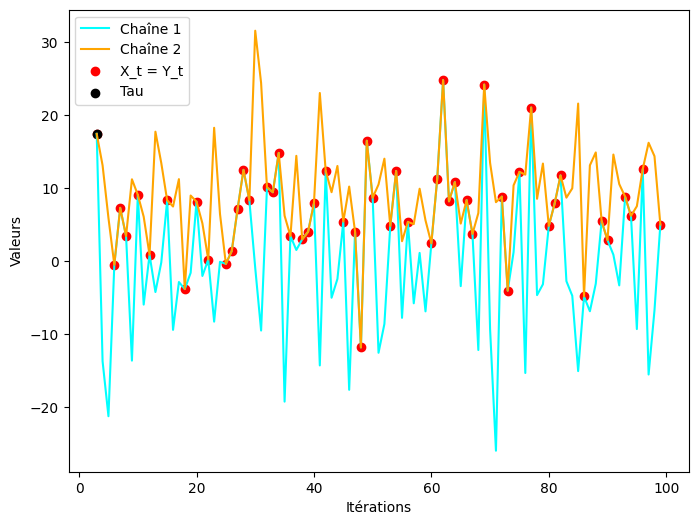

In [45]:
def algorithm2(values, length):
    def normal_mean(value, evaluate):
        """  Densité d'une loi normale de moyenne value et de variance 10, évaluée en evaluate      
        """
        return np.exp(-(evaluate - value)**2 / 20) / (np.sqrt(20 * np.pi))
    simulation = []

    for i in range(length):
        x2, U = npr.normal(values[0], 10), npr.uniform()
        rapport = normal_mean(values[1], x2) / normal_mean(values[0], x2)
        if U <= rapport: 
            y2 = x2
        else: 
            repeat = True 
            while repeat: 
                y3, V = npr.normal(values[1], 10), npr.uniform()
                rapport = normal_mean(values[0], y3) / normal_mean(values[1], y3)
                if rapport <= V: 
                    y2 = y3
                    repeat = False
        simulation.append([i, x2, y2])
    return np.array(simulation) 

simulation1 = algorithm2(np.array([0.25, 4]), 10**2)
cut = 3
simulation = simulation1[cut:]
plt.figure(figsize=(8,6))
plt.plot(simulation[:,0], simulation[:,1], label = "Chaîne 1", color = "cyan")
plt.plot(simulation[:,0], simulation[:,2], label = "Chaîne 2", color = 'orange')
plt.scatter(simulation[simulation[:,1] == simulation[:,2]][:,0], simulation[simulation[:,1] == simulation[:,2]][:,1], color='red', label="X_t = Y_t")
plt.scatter(simulation[simulation[:,1] == simulation[:,2]][0,0],simulation[simulation[:,1] == simulation[:,2]][0,1], color='black', label="Tau")
plt.plot()
plt.xlabel("Itérations")
plt.ylabel("Valeurs")
plt.legend()
plt.show()

array([[100.        , -10.99980613,  14.78993544],
       [101.        ,  13.08402383,  13.08402383],
       [102.        , -10.75189546,  14.26597486],
       ...,
       [897.        ,   7.24497864,   7.24497864],
       [898.        ,   7.05672831,   7.05672831],
       [899.        , -14.35472573,   3.75561378]])